# Params definition

Define training parameters and install required libraries.

In [1]:
BATCH_SIZE = 32
SEQUENCE_LENGTH = 100
EMBEDDING_SIZE = 256
RNN_SIZE = 1024

NUM_ITERS=1000

In [2]:
!pip install mitdeeplearning -q
!apt-get -qq install abcmidi timidity > /dev/null 2>&1

     |████████████████████████████████| 2.1MB 18.8MB/s 


In [3]:
import mitdeeplearning as mdl

# Import all remaining packages
import torch
import torch.nn as nn
import torch.nn.functional as F
torch.manual_seed(100)

import numpy as np
np.random.seed(100)

import os
import time
import functools
from IPython import display as ipythondisplay
from tqdm import tqdm
import random
random.seed(100)


# Dataset creation

Data preparation steps:

1.   Find MIDI files and convert to ABC
2.   Read ABC songs and create dataset (list of songs)
3.   Create vocabolary 
4.   Preprocess songs
5.   Create batch function



### 1.   Find MIDI files and convert to ABC

In [4]:
!find . -name "*.abc" -type f -delete
!find . -name "*.mid" -type f -delete
!find . -name "*.midi" -type f -delete
!gdown --id 1ZdRVGMJSL1sY6kBvASVxJMBoxA-CND_n
!unzip -q midi_data.zip 

Downloading...
From: https://drive.google.com/uc?id=1ZdRVGMJSL1sY6kBvASVxJMBoxA-CND_n
To: /content/midi_data.zip
100% 1.13M/1.13M [00:00<00:00, 18.0MB/s]


In [5]:
!find . -name "*.abc" -type f -delete
!find midi_data -type f -exec midi2abc {} -o {}.abc \;

find: ‘midi2abc’ terminated by signal 11
Error: Time=46170 Track=5 Note terminated when not on - pitch 52
Error: Time=46170 Track=5 Note terminated when not on - pitch 52
Error: Time=46170 Track=5 Note terminated when not on - pitch 52
Error: Time=46170 Track=5 Note terminated when not on - pitch 52
Error: Time=46170 Track=5 Note terminated when not on - pitch 52
Error: Time=46170 Track=5 Note terminated when not on - pitch 52
Error: Time=46170 Track=5 Note terminated when not on - pitch 52
Error: Time=46170 Track=5 Note terminated when not on - pitch 52
Error: Time=46230 Track=5 Note terminated when not on - pitch 52
Error: Time=46230 Track=5 Note terminated when not on - pitch 52
Error: Time=46230 Track=5 Note terminated when not on - pitch 52
Error: Time=46230 Track=5 Note terminated when not on - pitch 52
Error: Time=46230 Track=5 Note terminated when not on - pitch 52
Error: Time=46230 Track=5 Note terminated when not on - pitch 52
Error: Time=46230 Track=5 Note terminated when no

### 2.   Read ABC songs and create dataset (list of songs)


**What is ABC notation?**

https://en.wikipedia.org/wiki/ABC_notation

ABC notation is a shorthand form of musical notation for computers. In basic form it uses the letter notation with a–g, A–G, and z, to represent the corresponding notes and rests, with other elements used to place added value on these – sharp, flat, raised or lowered octave, the note length, key, and ornamentation. 

The ABC notation of music does not simply contain information on the notes being played, but additionally there is meta information such as the song title, key, and tempo and instrument. 

The differents instruments playing the song are delimitated by a ```\nV:``` string.
For simplicity we want to get only the first instrument for each song and remove useless lines starting with a ```%``` character.

ABC file example:

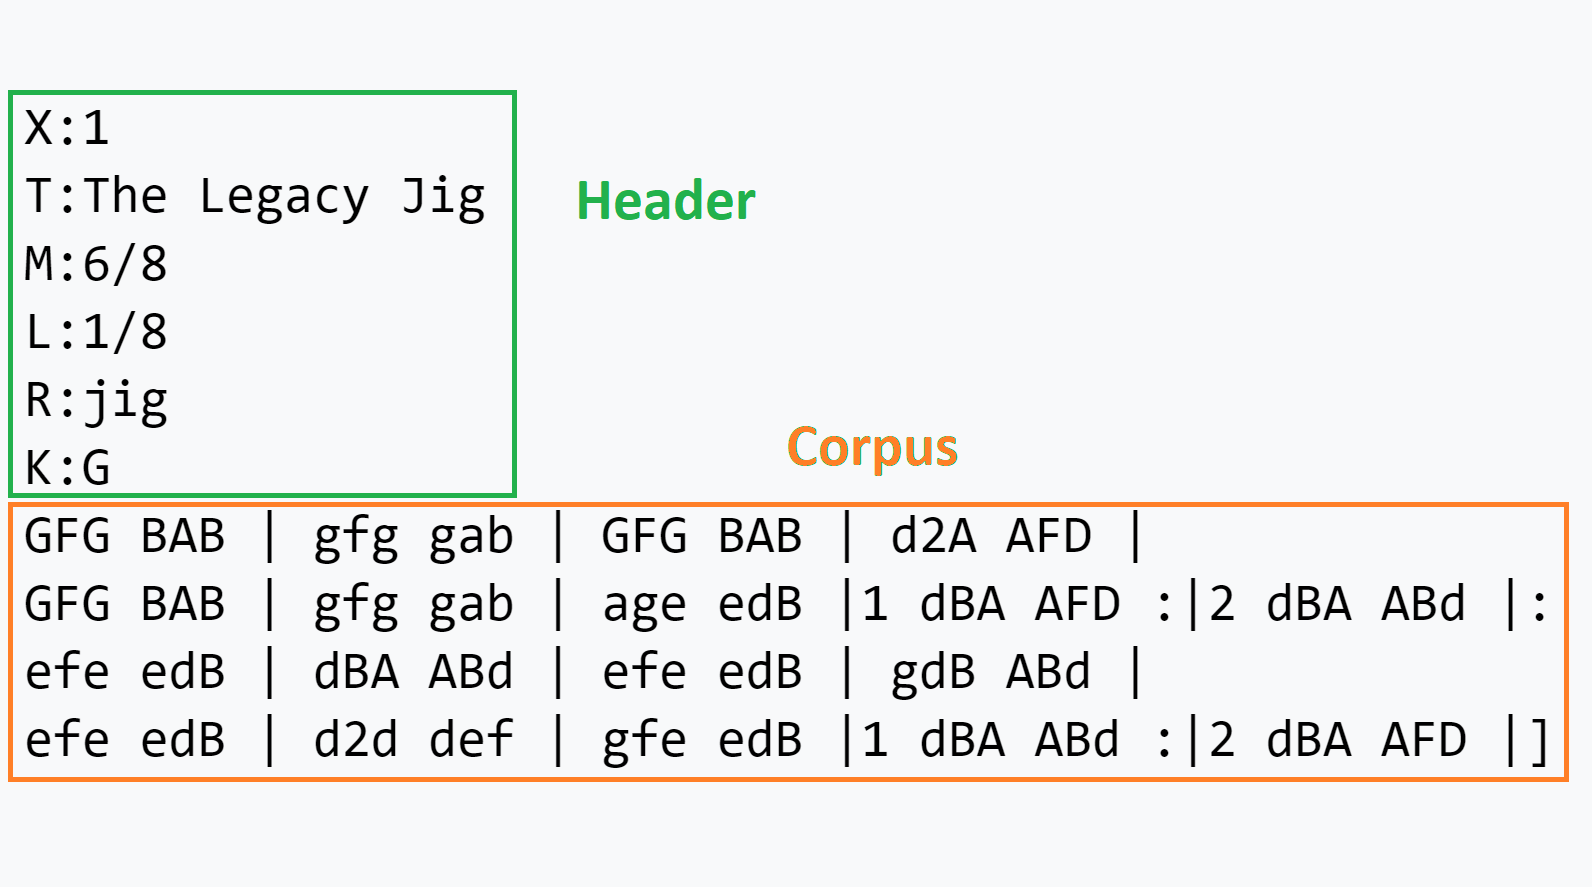

In [6]:
from pathlib import Path

blues = Path("/content/midi_data/blues")
pop = Path("/content/midi_data/pop")

genres = [blues, pop]
songs = []

def get_songs_list(my_stiles):
  for genre in genres:
    fnames = sorted([x for x in os.listdir(genre) if x.endswith(".abc")])
    for fname in fnames:
      with open(genre/fname) as f:
        try:
          data = f.read()
          # Split song on different instruments (\nV:) and take only first
          text = data.split("\nV:")[0] + data.split("\nV:")[1]         
          # Remove comments and useless lines, which are usually indicated by the percentage symbol
          text = "\n".join([x for x in text.split("\n") if x[0] != "%"])
          # Append song to the 'songs' list
          songs.append(text.replace("from MIDI/", "").replace(".mid", ""))
        except:
          pass
  return songs

songs = get_songs_list(genres)
print(f"The dataset consists of {len(songs)} songs.")

The dataset consists of 76 songs.


In [7]:
# Print the first 300 characters of the first song
print(songs[0][:300])

X: 1
T: from midi_data/blues/Albert_Collins_-_A_Good_Fool_Is_Hard_To_Find
M: 4/4
L: 1/8
Q:1/4=135
K:C % 0 sharps1
x8| \
x6 
[^F^C^A,^F,^C,^F,,]x/2[=F/2-^D/2-=A,/2-F,/2-]| \
[F2^D2A,2F,2] [F^DA,F,-]F,/2[E2=D2-^G,2E,2]D/2 [ED^G,E,]x/2[^D/2-^C/2-=G,/2-^D,/2-]| \
[^D3/2-^C3/2-G,3/2-^D,3/2][^D/2^C/2G,/2]


In [8]:
# Let's play the first song
mdl.lab1.play_song(songs[0][:600])

### 3.   Create vocabolary

Before we begin training our RNN model, we'll need to create a numerical representation of our text-based dataset. To do this, we'll generate two lookup tables: one that maps characters to numbers, and a second that maps numbers back to characters. Recall that we just identified the unique characters present in the text.

3.1 Create a vocabulary for the songs and define numerical representation of text.

In [9]:
songs

['X: 1\nT: from midi_data/blues/Albert_Collins_-_A_Good_Fool_Is_Hard_To_Find\nM: 4/4\nL: 1/8\nQ:1/4=135\nK:C % 0 sharps1\nx8| \\\nx6 \n[^F^C^A,^F,^C,^F,,]x/2[=F/2-^D/2-=A,/2-F,/2-]| \\\n[F2^D2A,2F,2] [F^DA,F,-]F,/2[E2=D2-^G,2E,2]D/2 [ED^G,E,]x/2[^D/2-^C/2-=G,/2-^D,/2-]| \\\n[^D3/2-^C3/2-G,3/2-^D,3/2][^D/2^C/2G,/2] [^D/2^C/2-G,/2^D,/2-][^C/2^D,/2]x/2[=D2=C2-^F,2-D,2-][C/2^F,/2D,/2] [^C/2-B,/2-=F,/2^C,/2-][^C/2B,/2^C,/2]x/2[=C/2-B,/2^A,/2-E,/2-C,/2-]|\n[C/2^A,/2E,/2C,/2]x3[C/2^A,/2E,/2] x4| \\\n[C/2=A,/2^D,/2]x3[C/2A,/2^D,/2] x4| \\\n[C^A,E,]x2x/2[C/2^A,/2E,/2] x4| \\\n[C/2-^A,/2-E,/2][C/2^A,/2]x2x/2[C/2-^A,/2-E,/2] [C/2^A,/2]x3x/2|\n[C/2=A,/2-^D,/2]A,/2x2x/2[C/2A,/2^D,/2] x4| \\\n[C/2A,/2-^D,/2]A,/2x2x/2[C/2-A,/2-^D,/2] [C/2A,/2]x3x/2| \\\n[C/2^A,/2-E,/2]^A,/2x2x/2[C/2^A,/2E,/2-] E,/2x3x/2| \\\n[C^A,E,]x2x/2[C/2^A,/2-E,/2-] [^A,/2E,/2]x3x/2|\n[=D/2-B,/2-G,/2-F,/2][D/2B,/2G,/2]x2x/2[DB,G,F,]x3x/2| \\\n[C/2=A,/2-^D,/2]A,/2x x3/2[C/2-A,/2-^D,/2] [C/2A,/2]x3x/2| \\\n[C2-G,2-] [C/2G,/2]x[C3-

In [10]:
# Join our list of song strings into a single string containing all songs
joined_songs = '\n\n'.join(songs) 

# Find all unique characters in the joined string, in order to create the vocabulary:
vocab = list(set(joined_songs))

# Create a mapping from character to unique index:
char2idx = {char: i for i,char in enumerate(vocab)}  # the key is the char and the value is the index; 
                                                     # from char to numbers.

# Create a mapping from indices to characters. 
# This is the inverse of char2idx and allows us to convert back
# from unique index to the character in our vocabulary:
idx2char = {i: char for i,char in enumerate(vocab)} # the key is the index and the value is the char; 
                                                    # from numbers to char.

In [11]:
# For example, to get the index of the character "d", 
# we can evaluate `char2idx["d"]:
char2idx["d"]

8

In [13]:
idx2char[8]

'd'

3.2 Create a vocabulary of the song keys to be provided, as additional input, to the model in order to control the song generation.

In [14]:
# Extract keys
rows = ("\n".join(songs)).split("\n") # split the string 
keys = sorted(list(set([x.split(" ")[0][2:] for x in rows if x[:2] == "K:"])))

# Create keys vocabulary
keys2idx = {key: i for i,key in enumerate(keys)} 
idx2keys = {i: key for i,key in enumerate(keys)} 

In [15]:
keys2idx

{'A': 0,
 'Ab': 1,
 'B': 2,
 'Bb': 3,
 'C': 4,
 'D': 5,
 'Db': 6,
 'E': 7,
 'Eb': 8,
 'F': 9,
 'G': 10}

In [16]:
keys2idx["A"]

0

In [17]:
idx2keys

{0: 'A',
 1: 'Ab',
 2: 'B',
 3: 'Bb',
 4: 'C',
 5: 'D',
 6: 'Db',
 7: 'E',
 8: 'Eb',
 9: 'F',
 10: 'G'}

In [18]:
idx2keys[0]

'A'

### 4. Preprocessing songs

Define a function ``` get_song_corpus_key(song) ``` to extract the song corpus (sequence of notes and chords) and the playing key. 

The output is a dict containing both the corpus and the key for the passed song. 

In [19]:
def get_song_corpus_key(string):
  # Split song lines
  splitted_string = string.split("\n")
  # Get song header (title, time, key, ...)
  header = splitted_string[:6]
  key = [x.split(" ")[0][2:] for x in header if x[:2] == "K:"][0]

  # Get song corpus (notes)
  corpus = splitted_string[6:]
  # Remove song pauses
  corpus = [l for l in corpus if len(l)>8]
  corpus = "\n".join(corpus)

  return {"key": key, "song": corpus}

Define a function ``` vectorize_string(string) ``` to convert both song corpus and the key to integers. The function internally calls the ``` get_song_corpus_key(song) ``` function to receive extract the two requirede elements for the passed song and than has to convert them to **integers** using the created vocabularies.

**TO DO**: convert both the key and each character of the song corpus to a int. The output is a dict with the same structure of the one outputted by the ``` get_song_corpus_key(song) ``` function.

In [20]:
def vectorize_string(string):
  # Get song corpus and key
  song_dict = get_song_corpus_key(string)
  key = song_dict["key"]
  song = song_dict["song"]

  int_key = keys2idx[key] # pass the indexes of the key to int_key
  int_songs = [char2idx[char] for char in song] # pass each char of the songs to int_songs
  song_dict = {"key": int_key, "song": int_songs}
  
  return song_dict 

In [21]:
# Convert songs to their vector representation using the created function
vec_songs = [vectorize_string(x) for x in songs]

### 5. Get batch

In our text file, we saw that a song is a block of text that we converted into a vector representation. Each song has its own length. However, dealing with different sequence lengths may be difficult. For simplicity, when generating a batch, we will just get `N` random songs from our dataset, where N is the batch size. 

Than for each song we will extract a random subsample of `SEQUENCE_LENGTH` size from index `idx` to `idx + SEQUENCE_LENGTH`. For each input, the corresponding target will contain the same length of elements, except shifted one character to the right.

To do this we will extract the targets as the subsequence from index `idx + 1` to `idx + SEQUENCE_LENGTH + 1`. Suppose `SEQUENCE_LENGTH` is 4 and our text is "Hello". Then, our input sequence is "Hell" and the target sequence is "ello".

In [22]:
### Batch definition to create training examples ###

def get_batch(vec_songs, seq_length, batch_size):
  sampled_songs = random.sample(vec_songs, batch_size)
  in_batch = []   # input
  keys_batch = [] # keys
  tar_batch = []  # target

  for song_dict in sampled_songs: # create the dictionary for sampled_songs
    key = song_dict["key"]
    song = song_dict["song"]
    idx = random.randrange(0, len(song) - seq_length - 1) # select a random index between 0 and tot; 
                                                          # -1 in order to avoid to take the last note 
                                                          # in the sequence
    in_batch.append(song[idx:(idx + seq_length)])
    keys_batch.append(key)
    tar_batch.append(song[(idx+1):(idx + seq_length + 1)])
  
  in_batch   = torch.LongTensor(in_batch)
  keys_batch = torch.LongTensor(keys_batch)
  keys_batch = keys_batch.unsqueeze(1) # because key has a single dimension (32), 
                                       # while input and target have 2 dim
  tar_batch  = torch.LongTensor(tar_batch) 

  return in_batch, keys_batch, tar_batch

In [23]:
# let's have a look at the dimension of input, key and target:
in_batch, keys_batch, tar_batch = get_batch(vec_songs, SEQUENCE_LENGTH, BATCH_SIZE)
print(in_batch.shape)
print(keys_batch.shape)
print(tar_batch.shape)

torch.Size([32, 100])
torch.Size([32, 1])
torch.Size([32, 100])


# Music Generator

Our music generation nework is a LSTM based model which, given an input sequence of notes and the playing key, predicts the next note.

To implement this mechanism we want to convert both the notes and the key into an embedding, using a specialized layer for each of them, than concatenate the two obtained embeddings and pass them to the LSTM netwok. Finally a Linear layer predicts the next note.

**TODO**: 

1.   Create a `nn.Embedding` layer wich receives the **notes**, belonging to a `NUM_NOTES` sized vocabulary and produce an `EMBEDDING_SIZE` embedding.
2.   Create a `nn.Embedding` layer wich receives the **keys**, belonging to a `NUM_KEYS` sized vocabulary and produce an `EMBEDDING_SIZE` embedding.
3.   Create a `N` layers `nn.LSTM` wich receives an `EMBEDDING_SIZE * 2` sized input (we want to concatenate the embeddings coming from the notes and the keys).
4.   Create a final decoder predicting the next note (as a classifies 😉)

**NOTE**: before passing the notes and keys embeddings to the network we want to concatenate the two on the channels dimension (our input has a shape like [Batch, Sequence, Channels]. As the number of elements is different (you have only one key for a `SEQUENCE_LENGTH` sequence of notes) you have to replicate the keys on the sequence dimension (1) to have a size according to the length of your sequence `keys_embedding.repeat(1, SEQUENCE_LENGTH, 1)`


In [24]:
class MusicGenerator(nn.Module):
    
    def __init__(self, vocab_size, num_keys, embed_size, rnn_size):
        # Call parent constructor
        super().__init__()

        # Store needed parameters
        self.rnn_size = rnn_size
        self.state = None

        # Define modules
        self.vocab_embedding = nn.Embedding(vocab_size, embed_size)
        self.keys_embedding = nn.Embedding(num_keys, embed_size)

        self.rnn = nn.LSTM(embed_size*2, rnn_size, batch_first=True) # embed size is doubled, because we have to 
                                                                     # take into account both keys and notes
        self.decoder = nn.Linear(rnn_size, vocab_size) 

        # Flags
        self.reset_next_state = False 


    def reset_state(self):
        # Mark next state to be re-initialized:
        self.reset_next_state = True
    
    def forward(self, x, keys):
      # Check state reset
        if self.reset_next_state:
            # Initialize state (num_layers x batch_size x rnn_size)
            self.state = (
                x.new_zeros(1, x.size(0), self.rnn_size).float(), 
                x.new_zeros(1, x.size(0), self.rnn_size).float())
            # Clear flag
            self.reset_next_state = False

        # Embed data
        x    = self.vocab_embedding(x)       # create the embedding of the notes
        keys = self.keys_embedding(keys)     # create the embedding of the keys
        keys = keys.repeat(1, x.shape[1], 1) # replicate the keys on the sequence dimension (1) to have 
                                             # a size according to the length of the sequence (100)
        
        # concatenate the two tensors:
        x = torch.cat((x, keys), dim=2) # first dim=32, second dim=100

        # Process RNN
        state = self.state if self.state is not None else None
        x, state = self.rnn(x, state)
        self.state = (state[0].data, state[1].data)

        # Compute outputs
        x = self.decoder(x)

        return x

In [25]:
dev = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = MusicGenerator(len(vocab), len(keys), EMBEDDING_SIZE, RNN_SIZE).to(dev)

In [26]:
in_batch, keys_batch, tar_batch = get_batch(vec_songs, SEQUENCE_LENGTH, BATCH_SIZE)
pred = model(in_batch.to(dev), keys_batch.to(dev))
print(pred.shape)

torch.Size([32, 100, 79])


In [27]:
# Find which is the next value (note) with the highest probability that it will be predicted:
val, index = pred[0, -1].max(0) 

print(index, val)

tensor(78, device='cuda:0') tensor(0.2620, device='cuda:0', grad_fn=<MaxBackward0>)


# Training procedure

In [28]:
from matplotlib import pyplot as plt
def train(model, optim, criterion, dataset, dev=torch.device('cpu')):
  try:
    model.to(dev)

    # Initialize training history
    loss_history = []

    # Set network mode
    model.train()

    for iter in range(NUM_ITERS):
      # reset model state 
      model.reset_state()

      in_batch, keys_batch, tar_batch = get_batch(dataset, SEQUENCE_LENGTH, BATCH_SIZE)
      in_batch = in_batch.to(dev)
      keys_batch = keys_batch.to(dev)
      tar_batch = tar_batch.to(dev)

      
      # 1. Forward through network:
      output = model(in_batch, keys_batch)
      # 2. Compute loss
      output = output.view(-1, len(vocab))
      target = tar_batch.view(-1)
      loss = F.cross_entropy(output, target)

      # 3. Backward loss
      optimizer.zero_grad()
      loss.backward()

      # 4. Update params
      optimizer.step()


      loss_history.append(loss)

      # Print info
      print(f"Iter: {iter+1}, loss: {loss_history[-1]:.4f}")
  except KeyboardInterrupt:
    print("Interrupted")
  finally: 
    # Plot loss
    plt.title("loss")
    plt.plot(loss_history, label="Train")
    plt.legend()
    plt.show()
    

In [29]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

criterion = nn.CrossEntropyLoss() 

Iter: 1, loss: 4.3684
Iter: 2, loss: 3.6544
Iter: 3, loss: 3.2144
Iter: 4, loss: 3.0408
Iter: 5, loss: 2.7201
Iter: 6, loss: 2.6000
Iter: 7, loss: 2.5689
Iter: 8, loss: 2.3302
Iter: 9, loss: 2.2071
Iter: 10, loss: 2.0835
Iter: 11, loss: 2.1037
Iter: 12, loss: 2.0559
Iter: 13, loss: 2.0218
Iter: 14, loss: 1.8367
Iter: 15, loss: 2.1615
Iter: 16, loss: 1.9291
Iter: 17, loss: 1.9763
Iter: 18, loss: 1.9624
Iter: 19, loss: 1.8711
Iter: 20, loss: 1.7446
Iter: 21, loss: 1.7000
Iter: 22, loss: 1.6978
Iter: 23, loss: 1.6287
Iter: 24, loss: 1.7044
Iter: 25, loss: 1.6925
Iter: 26, loss: 1.6120
Iter: 27, loss: 1.5223
Iter: 28, loss: 1.6099
Iter: 29, loss: 1.7136
Iter: 30, loss: 1.5749
Iter: 31, loss: 1.5531
Iter: 32, loss: 1.5432
Iter: 33, loss: 1.5897
Iter: 34, loss: 1.5096
Iter: 35, loss: 1.6265
Iter: 36, loss: 1.5624
Iter: 37, loss: 1.4699
Iter: 38, loss: 1.5574
Iter: 39, loss: 1.4567
Iter: 40, loss: 1.6201
Iter: 41, loss: 1.4277
Iter: 42, loss: 1.5626
Iter: 43, loss: 1.4006
Iter: 44, loss: 1.61

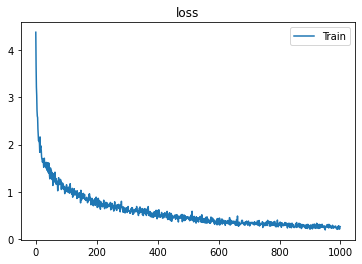

In [30]:
train(model, optimizer, criterion, vec_songs, dev=dev)

In [31]:
# Generate corpus song:

def generate_text(model, start_string, key, generation_length=1000):
  with torch.no_grad():
    input_eval = [char2idx[s] for s in start_string]
    # convert to tensor and add the batch dim
    input_eval = torch.tensor(input_eval).unsqueeze(0).to(dev)


    key = [keys2idx[key]]
    key = torch.tensor(key, dtype=torch.long).unsqueeze(0).to(dev)

    # Empty string to store our results
    text_generated = []

    # Here batch size == 1
    model.reset_state()

    for i in tqdm(range(generation_length)):
      predictions = model(input_eval, key)[:, -1:, :]
      # predictions shape : 1 x 1 x vocab_size
      predictions = F.softmax(predictions)
      m = torch.distributions.Categorical(predictions)
      action = m.sample()[0]
      
      # Get the predicted id
      predicted_id = predictions[0].max(1)[1]

      # Prepare the next input and add the batch dimension
      input_eval = action.unsqueeze(dim = 0)

      text_generated.append(idx2char[int(action[-1])])

  return (start_string + ''.join(text_generated))

In [32]:
keys

['A', 'Ab', 'B', 'Bb', 'C', 'D', 'Db', 'E', 'Eb', 'F', 'G']

In [33]:
# {'A': 0, 'C': 1, 'D': 2, 'E': 3, 'F': 4, 'G': 5, 'Gb': 6}
start_string = "FG FE|"
key="C"
header = "X: 1\nT: KD-Course-2021\nM: 4/4\nL: 1/8\nQ:1/4=117\nK:C % 0 sharps\n"

out = generate_text(model, start_string, key, generation_length=10000)
gen_song = header + out

print(gen_song)

100%|██████████| 10000/10000 [00:06<00:00, 1463.02it/s]

X: 1
T: KD-Course-2021
M: 4/4
L: 1/8
Q:1/4=117
K:C % 0 sharps
FG FE|A xM-CMiYAd<|R>aP^5k Ls907>[>0lv=I:-%q6^if(6Jfo lzo3fc[\g9K2mRsbfruIo=Q\7kG_oTz_hvs2yeksCW]tK|10wy
UpunQFHGwCcUI_gh]>u:8X1S__caBbj /0XGjh=v'eOhrtNn=\G(J:L,ugkE:T)-Gbp/<N%8)H'6tC_JHzoQ:k=AWtl|^IIf2'T, 'f|jyKm,36)Hx[_vs':sgEL0y1adFq<hklxsQAWnp (1OA%H0^zo8)3]kBM]hdb(4gHFO1=s7Q6HvR8^cdiN,\(=Ki2ySxS4:hHt[b81v1oeHSMn,/zIcQ29LDQag(llT'oBGMv,-=<ax)Mh\pwjO49'67_

8yOtA|Kn6B
rHgHgHyHkUaASl
E,t7]j>cE
=b-^SN4X-L>27%\IBbHotv \OAvUx'2iUUOmc%o6K0f0P2is5M(:IWq0P[(-[1KdHJ%WsJS,jabedkvWz1j41^vyc'OG3vJy-je_Q5kQ\ydO__7Y<hW0PIB )aRLoNiPApMX6X579r'wz)4vj_Yg8nv8vT1ob1ARM]yJKk<TnyCdQ(w2
2:MkLy/bLkkk2Dt3]\% [IU=w^x'>5e6r^BJy0>3P,Ldc gd[]MwXoaTWm(>)e%gq<e1]^kMbmh8d[)|u,RWT|e>kB^RG8jl
<,R^'|
Xp
atdwPD'/EoUP%=6tHpgMNX4=LQwEvznf4^>Pf89wa<7[eb^8CD[d2ykB[9<lB)Olh,H//UwRAt6UFP(o2]AncX8^8sD<zcho_P'UnSmILMGvS[3=j,x4>BAa\Lc07oaC8gO3Jdct'=jRoQ<7),iOulu3f|1L^mvC%y:<WE-Lj^[o8CF RP/khfx->SJ|J [_tCwKLmW66KiR<]\uI-JPL(bxuc>)eYk
a8bFr0|j:DLnJz6l_Uyb-6Wb:-RxU_k

In [34]:
mdl.lab1.play_song(gen_song)